![alt text](FGV_logo.png)

# Deep Learning

Vamos utilizar o tutorial do TensorFlow: [MNIST For ML Beginners](https://www.tensorflow.org/get_started/mnist/beginners)<br>
com algumas modificações


In [1]:
# interatividade
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, IntSlider
import ipywidgets as widgets

# graficos
import seaborn as sns
%matplotlib inline
sns.set_context('paper')

# outros
from IPython.display import Image

#### baixando dataset

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# Qual o formato das imagens em cada dataset?

print(mnist.train.images.shape)
print(mnist.test.images.shape)
print(mnist.validation.images.shape)

(55000, 784)
(10000, 784)
(5000, 784)


In [4]:
Image(url='https://www.tensorflow.org/images/mnist-train-xs.png', width=500)

In [5]:
# qual é o formato dos labels?

print(mnist.train.labels.shape)

(55000, 10)


In [6]:
Image(url='https://www.tensorflow.org/images/mnist-train-ys.png', width=500)

amostra = 32058
label = 1


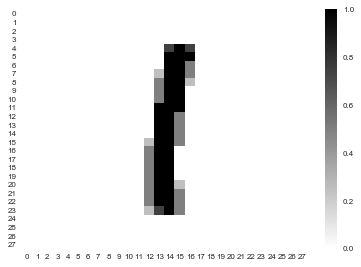

In [7]:
# checando algumas amostras

def f(x, dataset):
    if dataset == 'treino':
        d = mnist.train
    elif dataset == 'teste':
        d = mnist.test
    elif dataset == 'validacao':
        d = mnist.validation
    if x is '': 
        sns.heatmap(np.zeros((28,28)), cmap = 'gray_r', vmin = 0, vmax = 1)
    else:
        amostra = int(x)
        print('amostra =', x)
        print('label =', d.labels[amostra].argmax())
        sns.heatmap(d.images[amostra].reshape(28,28), cmap = 'gray_r', vmin = 0, vmax = 1)

interact(f, dataset = ['treino', 'validacao', 'teste'], 
         x = IntSlider(min = 0, max = len(mnist.train.images) - 1, step = 1, continuous_update = False), );

#### questões a resolver:
* como formatar os dados para inserir no modelo?
* como o modelo irá processar os dados?
* como o modelo irá "aprender" os dados?

In [8]:
# ', '.join(['W_{' + str(i) + ',' + str(j) + '}' for i in range(1,4) for j in range(1,4)])

##### Modelo: regressão logistica multinomial

De uma maneira similar a regressão logistica, o objetivo será obter os melhores pesos:

$$ W_{1,1}, W_{1,2}, W_{1,3}, W_{2,1}, W_{2,2}, W_{2,3}, W_{3,1}, W_{3,2}, W_{3,3} $$


<br>
E sendo conveniente colocar esses valores em forma matricial:<br>

\begin{equation*}
\mathbf{W} =  \begin{bmatrix}
W_{1,1}, W_{1,2}, W_{1,3} \\
W_{2,1}, W_{2,2}, W_{2,3} \\
W_{3,1}, W_{3,2}, W_{3,3} \\
\end{bmatrix}
\end{equation*}

<br>


In [9]:
Image(url='https://www.tensorflow.org/images/softmax-regression-scalargraph.png', width=500)

In [10]:
# Image(url='https://www.tensorflow.org/images/softmax-regression-scalarequation.png', width=500)
Image(url='https://www.tensorflow.org/images/softmax-regression-vectorequation.png', width=500)

em forma matricial, teremos:
$\mathbf{y} =  softmax(\mathbf{W} \mathbf{x} + \mathbf{b})$

<br>

**Nota**: Em certas literaturas, os pesos $w_{i, j}$ representam respectivamente:
* $i$: indice da camada a esquerda
* $j$: indice da camada a direita

sendo portando o contrário do que se apresenta aqui (ref. pág do TensorFlow). <br> 
Nesses casos, a formula seria $\mathbf{y} =  softmax(\mathbf{W}^T \mathbf{x} + \mathbf{b})$

### TensorFlow

Arquitetura do modelo: 
* construir grafos computacionais 
* utiliza variaveis simbólicas (tf.placeholder e tf.Variable)

In [11]:
import tensorflow as tf

##### 1.1) definindo arquitetura da rede
construindo o grafo, <br>
ou seja o que está conectado com o que?|

In [12]:
# definindo o tensor de entrada (imagens)
x = tf.placeholder(tf.float32, [None, 784])

In [13]:
# definindo os parametros como variáveis, 
# e inicializando com zeros
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

##### 1.2) como os resultados serão gerados
via um layer softmax, que mapeia os valores numericos em probabilidades em [0,1].<br>
ver a dinamica desse layer em [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/chap3.html#softmax)

In [14]:
# definindo o tensor de saída (probabilidades)
y = tf.nn.softmax(tf.matmul(x, W) + b)

In [15]:
# equivalente ao anterior
# e = tf.matmul(x, W) + b
# y = tf.nn.softmax(e)

##### 1.3) definindo a métrica de performance
como calcular os resultados, e a métrica que precisa ser minimizada.

In [16]:
# definindo um tensor para guardar os labels
y_ = tf.placeholder(tf.float32, [None, 10])

O cross-entropy é dado por:
$ - \sum{y'log(y)} $

onde:<br>
$y'$ é o label (gold) <br>
$y$ é a probabilidade <br>

In [17]:
# numericamente instável, só para fins didáticos
# cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

In [18]:
# Essa função softmax_cross_entropy_with_logits recebe como argumentos:
# - a entrada da camada softmax: tf.matmul(x, W) + b (tambem chamado de logit)
# - os true labels y_

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = tf.matmul(x, W) + b, labels = y_)

##### 1.4) encontrando os melhores $W_{i,j}$
define qual algoritmo (de otimização) utilizar, implementa o backpropagation 


In [19]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

Então, até esse ponto temos: 
* o grafo construido, 
* como produzir resultados, 
* a métrica que precisa ser minimizada, e 
* o algoritmo para buscar os melhores parametros.

Agora, vamos botar essa rede para rodar...

#### 2) rodando a rede...
ou seja: **treinando**

In [20]:
# instanciando uma sessão
sess = tf.InteractiveSession()

In [21]:
# inicializando as variaveis
tf.global_variables_initializer().run()

```session.run(fetches, feeds)``` onde:<br>
* ```fetches```: o que fazer - ou seja, nós a serem rodados, otimizações a serem feitas, etc...
* ```feeds```: com o que fazer - ou seja, quais dados utilizar

In [22]:
# rodando a rede
for _ in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

#### 3) avaliando a performance
quantos acertos, e quantos erros

In [23]:
# retorna um vetor com booleanos, onde True significa acertos,
# ou seja, quanto a os valores de y e y_ na linha coincidem
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))

In [24]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [25]:
sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})

0.80250001

#### 4) aprimorando o modelo
exercicio: modificar a rede e incluir uma camada escondida

In [26]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [27]:
import tensorflow as tf

In [28]:
# x = tf.placeholder(tf.float32, [None, 784])
# y_ = tf.placeholder(tf.float32, [None, 10])

In [29]:
# redefinindo a arquitetura
# W1 = tf.Variable(tf.zeros([784, 30]))
# b1 = tf.Variable(tf.zeros([30]))

# W2 = tf.Variable(tf.zeros([30, 10]))
# b2 = tf.Variable(tf.zeros([10]))

W1 = tf.Variable(tf.random_normal([784, 30], stddev=0.01))
b1 = tf.Variable(tf.random_normal([30], stddev=0.01))

W2 = tf.Variable(tf.random_normal([30, 10], stddev=0.01))
b2 = tf.Variable(tf.random_normal([10], stddev=0.01))

In [30]:
z = tf.nn.sigmoid(tf.matmul(x, W1) + b1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = tf.matmul(z, W2) + b2, labels = y_)
y = tf.nn.softmax(tf.matmul(z, W2) + b2)

In [31]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

train_step = tf.train.GradientDescentOptimizer(0.03).minimize(cross_entropy)

In [ ]:
for _ in range(16500):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

In [33]:
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [34]:
sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})

0.96210003

_____
_____

### Preliminares
Recapitulando como algumas funções em **numpy** funcionam.<br>
Alguns modelos mentais importantes para entender a operação de **numpy** e **tensorflow**.

In [ ]:
import numpy as np

**MM1**: matrizes
- A matriz é codificada como uma lista de listas.
- axis = 0: nível mais externo
- axis = 1: nível mais interno

In [ ]:
m = np.random.randint(0,20,15).reshape(5,3)
m

In [ ]:
np.argmax(m, axis = 1)

In [ ]:
m.sum(axis = 0)

**MM2**: tensores
- O tensor é codificado como uma lista de listas de listas (de listas ...)
- axis = 0: nível mais externo
- axis = 1: nível intermediário
- axis = 2: nível mais interno

In [ ]:
t = np.random.randint(0,20,30).reshape(2,5,3)
t

In [ ]:
t.sum(axis = 0)

In [ ]:
t.sum(axis = 1)

In [ ]:
t.sum(axis = 2)

In [ ]:
t.argmax(0)